# 第4章 多层感知机

## 4.1 多层感知机

### 练习4.1.1

计算pReLU激活函数的导数。

**解答：**

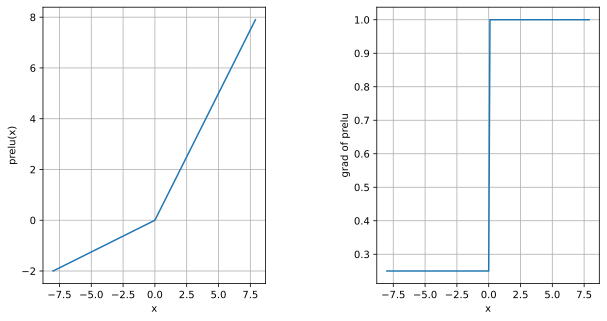

In [252]:
%matplotlib inline
import torch
from d2l import torch as d2l
import numpy  as np
#torch.nn.PReLU(num_parameters=1,init=0.25)不用d2l时的PReLU 函数 其中 a 由init设置 同时它是一个可学习的参数
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.prelu(x,weight=torch.tensor(0.25))
d2l.plt.figure(figsize=(10, 5)) 
d2l.plt.subplot(121)
d2l.plot(x.detach(), y.detach(), 'x', 'prelu(x)', figsize=(5, 2.5))
d2l.plt.subplot(122)
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of prelu', figsize=(5, 2.5))
d2l.plt.subplots_adjust(wspace =0.5, hspace =0)

### 练习4.1.2

证明一个仅使用ReLU（或pReLU）的多层感知机构造了一个连续的分段线性函数。

**解答：**

In [36]:
x = torch.arange(-8.0, 8.0, 0.1)
y = torch.relu(x)
x[x<=0]=0
print('ReLU')
print(y==x)
x = torch.arange(-8.0, 8.0, 0.1)
a=torch.tensor(0.25)
y = torch.prelu(x,weight=a)
x[x<=0]=a*x[x<=0]
print('PReLU')
print(y==x)

ReLU
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, Tru

### 练习4.1.3
证明$\operatorname{tanh}(x) + 1 = 2 \operatorname{sigmoid}(2x)$。

**解答：** $左边=\operatorname{tanh}(x) + 1 =\frac{1 - \exp(-2x)}{1 + \exp(-2x)}+1= \frac{2}{1 + \exp(-2x)}$   $右边= 2 \operatorname{sigmoid}(2x)= \frac{2}{1 + \exp(-2x)}$ 左边=右边

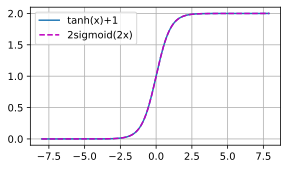

In [203]:
%matplotlib inline
import torch
from d2l import torch as d2l
x = torch.arange(-8.0, 8.0, 0.1)
y1 = torch.tanh(x)+1.0
y2 = 2.0*torch.sigmoid(2.0*x)

# d2l.plot(x.detach(), y1.detach(), 'x', 'tanh(x)+1',figsize=(4.5, 2.5))

# d2l.plot(x.detach(), y2.detach(), 'x', '2sigmoid(2x)',figsize=(4.5, 2.5))


d2l.plot(x.detach().numpy(), [y1.detach(), y2.detach()],
         legend=['tanh(x)+1','2sigmoid(2x)'], figsize=(4.5, 2.5))
#plt.subplots_adjust(wspace =1, hspace =0)


### 练习4.1.4

假设我们有一个非线性单元，将它一次应用于一个小批量的数据。这会导致什么样的问题？

**解答：**

## 4.2 多层感知机的从零开始实现

### 练习4.2.1

在所有其他参数保持不变的情况下，更改超参数`num_hiddens`的值，并查看此超参数的变化对结果有何影响。确定此超参数的最佳值。

**解答：**  256到376范围内num_hiddens得到结果基本一致，所以num_hiddens取256，能保证其他参数不变时得到最佳的结果。

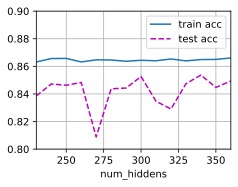

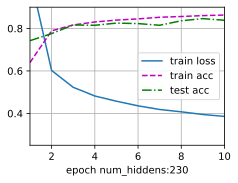

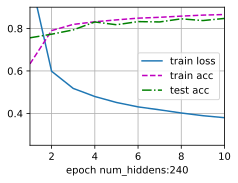

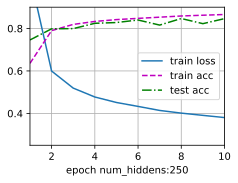

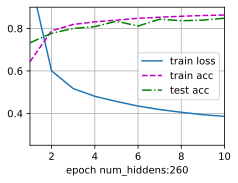

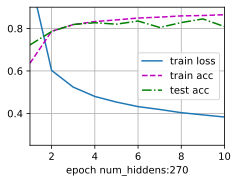

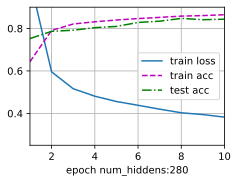

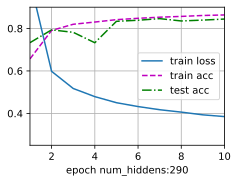

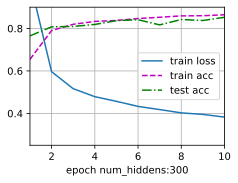

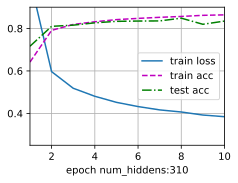

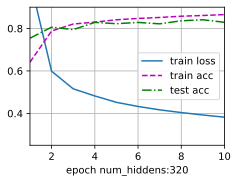

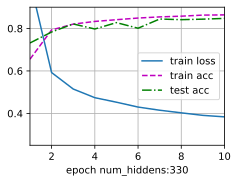

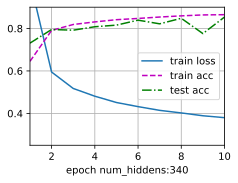

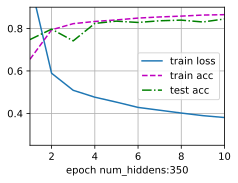

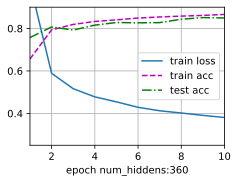

In [145]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

train_iter, test_iter = d2l.load_data_fashion_mnist(256, resize=None)

def initweight(num_inputs=784, num_outputs=10, num_hiddens = 256):
    W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True) * 0.01)
    b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
    W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs, requires_grad=True) * 0.01)
    b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))
    params = [W1, b1, W2, b2]
    return W1,b1,W2,b2, params

def mytrain(num_hiddenslist, train_iter, test_iter, loss, num_epochs,lr,showtrain=1): 
    num_inputs=784
    num_outputs=10
    animatornum_hiddens = d2l.Animator(xlabel='num_hiddens', xlim=[num_hiddenslist[0],num_hiddenslist[-1]], ylim=[0.8, 0.9],
                        legend=[ 'train acc', 'test acc'])
    for num_hiddens in num_hiddenslist:
        
        W1,b1,W2,b2, params=initweight(num_hiddens=num_hiddens)
        updater = torch.optim.SGD(params, lr=lr)
        def relu(X):
            a = torch.zeros_like(X)
            return torch.max(X, a)
        def net(X):
            X = X.reshape((-1, num_inputs))
            H = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
            return (H@W2 + b2)
        if showtrain==1:
            animator =d2l.Animator(xlabel=f'epoch num_hiddens:{num_hiddens}', xlim=[1, num_epochs], ylim=[0.25, 0.9],legend=['train loss', 'train acc', 'test acc'])
        for epoch in range(num_epochs):
            train_metrics = d2l.train_epoch_ch3(net, train_iter, loss, updater)
            test_acc = d2l.evaluate_accuracy(net, test_iter)
            if showtrain==1:
                animator.add(epoch + 1, train_metrics + (test_acc,))
        train_loss, train_acc = train_metrics
        print(f'num_hiddens={num_hiddens},train_loss={train_loss}, train_acc={train_acc},test_acc={test_acc}')
        animatornum_hiddens.add(num_hiddens,(train_acc,test_acc))
        assert train_loss < 0.5, train_loss
        assert train_acc <= 1 and train_acc > 0.7, train_acc
        assert test_acc <= 1 and test_acc > 0.7, test_acc
        
# W1,b1,W2,b2, params=initweight()
# def relu(X):
#     a = torch.zeros_like(X)
#     return torch.max(X, a)
# def net(X):
#     X = X.reshape((-1, num_inputs))
#     H = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
#     return (H@W2 + b2)
loss = nn.CrossEntropyLoss(reduction='none')
num_epochs, lr = 10, 0.1
num_hiddenslist=list(range(230,370,10))
mytrain(num_hiddenslist,train_iter, test_iter, loss, num_epochs,lr)
# pirnt(train_loss, train_acc,test_acc)

### 练习4.2.2
尝试添加更多的隐藏层，并查看它对结果有何影响。

**解答：**

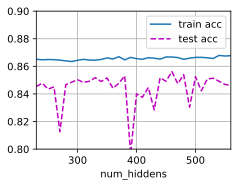

In [146]:
loss = nn.CrossEntropyLoss(reduction='none')
num_epochs, lr = 10, 0.1
num_hiddenslist=list(range(230,570,10))
mytrain(num_hiddenslist,train_iter, test_iter, loss, num_epochs,lr,0)

### 练习4.2.3

改变学习速率会如何影响结果？保持模型架构和其他超参数（包括轮数）不变，学习率设置为多少会带来最好的结果？

**解答：** 较大的学习速率可以让loss 下降更快，在初期更快的训练模型，但也可能造成更新参数值过大 ,从而导致 参数在最优解附近来回跳跃无法收敛或者收敛在错误的值。最理想的学习率不是固定值, 而是一个随着训练次数衰减的变化的值, 也就是在训练初期, 学习率比较大, 随着训练的进行, 学习率不断减小, 直到模型收敛.

num_inputs=784, num_outputs=10, num_hiddens =256
num_inputs=784, num_outputs=10, num_hiddens =256
num_inputs=784, num_outputs=10, num_hiddens =256
num_inputs=784, num_outputs=10, num_hiddens =256


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


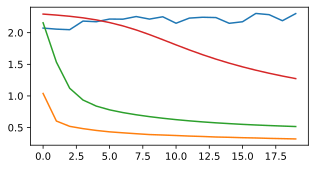

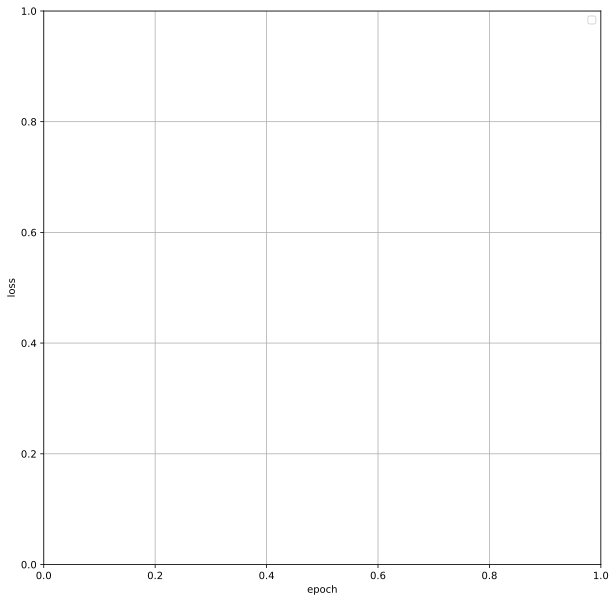

In [255]:
listlr=[1.0,0.1,0.01,0.001]
train_iter, test_iter = d2l.load_data_fashion_mnist(256, resize=None)
num_epochs=20

for lr in listlr:
    num_inputs=784; num_outputs=10; num_hiddens = 256;
    W1,b1,W2,b2, params=initweight()
    updater = torch.optim.SGD(params, lr=lr)
    epoch_loss=[]
    def relu(X):
        a = torch.zeros_like(X)
        return torch.max(X, a)
    def net(X):
        X = X.reshape((-1, num_inputs))
        H = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
        return (H@W2 + b2)
    for epoch in range(num_epochs):
        train_metrics = d2l.train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = d2l.evaluate_accuracy(net, test_iter)
        epoch_loss.append(train_metrics[0])
    train_loss, train_acc = train_metrics
    d2l.plt.plot(range(num_epochs), epoch_loss, label= (f'lr={lr}') )
#     assert train_loss < 0.5, train_loss
#     assert train_acc <= 1 and train_acc > 0.7, train_acc
#     assert test_acc <= 1 and test_acc > 0.7, test_acc
d2l.plt.figure(figsize=(10, 10)) 
d2l.plt.legend();
d2l.plt.xlabel('epoch')
d2l.plt.ylabel('loss')
d2l.plt.grid();
d2l.plt.show();

### 练习4.2.4

通过对所有超参数（学习率、轮数、隐藏层数、每层的隐藏单元数）进行联合优化，可以得到的最佳结果是什么？

**解答：**

### 练习4.2.5

描述为什么涉及多个超参数更具挑战性。

**解答：** 超参数无法通过常规的优化手段确定，每次调整超参数要依据训练结果导致调整一次需要的成本很大，而过多的超参数将导致更多的参数组合，使得通过训练来确定好最优的超参数很困难。

### 练习4.2.6

如果想要构建多个超参数的搜索方法，请想出一个聪明的策略。

**解答：** 根据过往的经验（文献或以前的实践）选定好一组超参数，从调整后计算成本最小的参数入手确定好它的值以后，再去确定计算成本比它大一点的参数，一步确定一个超参数，最后得到所有超参数的值，然后重复之前步骤，直到结果满意为止。

## 4.3 多层感知机的简洁实现

### 练习4.3.1

尝试添加不同数量的隐藏层（也可以修改学习率），怎么样设置效果最好？

**解答：**

### 练习4.3.2

尝试不同的激活函数，哪个效果最好？

**解答：** ReLU效果最好，Tanh次之，Sigmoid最差训练损失最后超过了0.5。

AssertionError: 0.5013982634862264

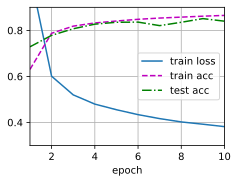

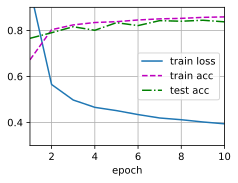

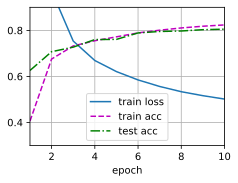

In [169]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

def train_diffactivation_function(ac):
    print(ac)
    net = nn.Sequential(nn.Flatten(),nn.Linear(784, 256))
    if ac=="Sigmoid":
        net.add_module('Sigmoid',nn.Sigmoid())
    elif ac=="Tanh":
        net.add_module('Tanh',nn.Tanh())
    else:
        net.add_module('ReLU',nn.ReLU())
    net.add_module('Linear',nn.Linear(256, 10))             
    net.apply(init_weights);
    batch_size, lr, num_epochs = 256, 0.1, 10
    loss = nn.CrossEntropyLoss(reduction='none')
    trainer = torch.optim.SGD(net.parameters(), lr=lr)
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)


train_diffactivation_function("ReLU")
train_diffactivation_function("Tanh")
train_diffactivation_function("Sigmoid")

### 练习4.3.3

尝试不同的方案来初始化权重，什么方法效果最好？

**解答：** 尝试了正态分布初始化权重，单位矩阵初始化权重，均匀分布初始化权重，在这个问题上单位矩阵初始权重的结果表现更好。

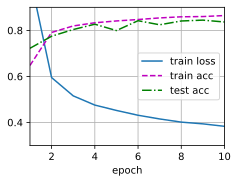

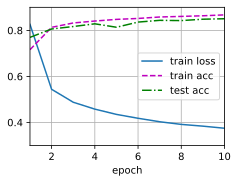

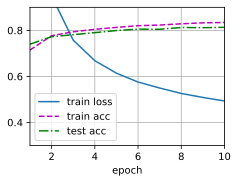

In [189]:
def normal_weights(m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, std=0.01)
            print("normal",m.weight)

def eye_weights(m):
       
        if type(m) == nn.Linear:
            nn.init.eye_(m.weight)
            print("eye",m.weight)

def uniform_weights(m):
       
        if type(m) == nn.Linear:
            nn.init.uniform_(m.weight, a=-1,b=1)
            print("uniform",m.weight)

def train_diffweight(w):
    net = nn.Sequential(nn.Flatten(),nn.Linear(784, 256),nn.ReLU(),nn.Linear(256, 10))             
    if w==0:
        net.apply(normal_weights);
    elif w==1:
        net.apply(eye_weights);
    else:
        net.apply(uniform_weights);
    batch_size, lr, num_epochs = 256, 0.1, 10
    loss = nn.CrossEntropyLoss(reduction='none')
    trainer = torch.optim.SGD(net.parameters(), lr=lr)
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)


    
train_diffweight(0)
train_diffweight(1)
train_diffweight(2)


## 4.4 模型选择、欠拟合和过拟合

### 练习4.4.1

这个多项式回归问题可以准确地解出吗？提示：使用线性代数。

**解答：** $$L(w)=\frac{1}{2} \sum_{i=1}^N\left(\sum_{j=0}^M w_j x_i^j-y_i\right)^2$$ $$取 \frac{\partial L(w)}{\partial w_k}=0\Rightarrow\frac{1}{2} \sum_{i=1}^N 2\left(\sum_{j=0}^M w_j x_i^j-y_i\right) \times x_i^k=0 \Rightarrow \sum_{i=1}^N \sum_{j=0}^M w_j x_i^{j+k}=\sum_{i=1}^N x_i^k y_i(k=0,1,2, \cdots, M)\Rightarrow X W=Y$$ $$其中X=\left[\begin{array}{ccccc}
N & \sum_{i=1}^N x_i & \sum_{i=1}^N x_i^2 & \cdots & \sum_{i=1}^N x_i^M \\
\sum_{i=1}^M x_i & \sum_{i=1}^M x_i^2 & \sum_{i=1}^M x_i^3 & \cdots & \sum_{i=1}^M x_i^{N+1} \\
\sum_{i=1}^M x_i^2 & \sum_{i=1}^M x_i^3 & \sum_{i=1}^M x_i^4 & \cdots & \sum_{i=1}^M x_i^{N+2} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
\sum_{i=1}^M x_i^N & \sum_{i=1}^M x_i^{N+1} & \sum_{i=1}^M x_i^{N+2} & \cdots & \sum_{i=1}^M x_i^{2 N}
\end{array}\right], \quad W=\left[\begin{array}{c}
w_0 \\
w_1 \\
w_2 \\
\vdots \\
w_M
\end{array}\right], \quad Y=\left[\begin{array}{c}
\sum_{i=1}^N y_i \\
\sum_{i=1}^N\left(x_i^2 y_i\right) \\
\vdots \\
\sum_{i=1}^N\left(x_i^N y_i\right)
\end{array}\right]
$$
$$ W=X^{-1} Y$$

### 练习4.4.2

考虑多项式的模型选择。
1. 绘制训练损失与模型复杂度（多项式的阶数）的关系图。观察到了什么？需要多少阶的多项式才能将训练损失减少到0?
2. 在这种情况下绘制测试的损失图。
3. 生成同样的图，作为数据量的函数。

**解答：** 在多项式阶数没有达到4之前阶数增加使得训练损失下降 当阶数超过4时训练误差几乎不变稳定在0.01这个数量级

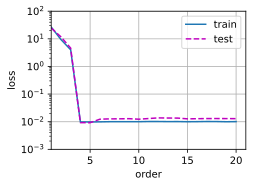

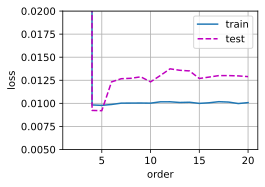

In [228]:
import math
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

def train2(order,num_epochs=400):
    animator = d2l.Animator(xlabel='order', ylabel='loss', yscale='log',
                            xlim=[1, order], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    animator2 = d2l.Animator(xlabel='order', ylabel='loss',
                            xlim=[1, order], ylim=[0.005, 0.02],
                            legend=['train', 'test'])
    for i in range(1,order):
        train_features, test_features, train_labels, test_labels=poly_features[:n_train, :i],poly_features[n_train:, :i],labels[:n_train], labels[n_train:]
        loss = nn.MSELoss(reduction='none')
        input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
        net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
        batch_size = min(10, train_labels.shape[0])
        train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),batch_size)
        test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
        trainer = torch.optim.SGD(net.parameters(), lr=0.01)
        for epoch in range(num_epochs):
            d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        animator.add(i, (d2l.evaluate_loss(net, train_iter, loss),d2l.evaluate_loss(net, test_iter, loss)))
    
        animator2.add(i, (d2l.evaluate_loss(net, train_iter, loss),d2l.evaluate_loss(net, test_iter, loss)))
        
    #print('weight:', net[0].weight.data.numpy())
    #return d2l.evaluate_loss(net, train_iter, loss),d2l.evaluate_loss(net, test_iter, loss)
train2(21,4000)

### 练习4.4.3

如果不对多项式特征$x^i$进行标准化($1/i!$)，会发生什么事情？能用其他方法解决这个问题吗？

**解答：**

### 练习4.4.4

泛化误差可能为零吗？

**解答：**  对于确定可解，且数据没有噪声的问题可以为零。

## 4.5 权重衰减

### 练习4.5.1

在本节的估计问题中使用$\lambda$的值进行实验。绘制训练和测试精度关于$\lambda$的函数图。可以观察到什么？

**解答：** 随着$\lambda$增加训练精度和测试进度逐渐靠近，但最终没有靠到一起。

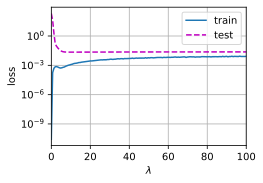

In [247]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)
def train_wd(wdlist):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    animator = d2l.Animator(xlabel='$\lambda$', ylabel='loss', yscale='log',
                            xlim=[wdlist[0],wdlist[-1]], legend=['train', 'test'])
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    for wd in wdlist:
        trainer = torch.optim.SGD([
            {"params":net[0].weight,'weight_decay': wd},
            {"params":net[0].bias}], lr=lr)
   
        for epoch in range(num_epochs):
            for X, y in train_iter:
                trainer.zero_grad()
                l = loss(net(X), y)
                l.mean().backward()
                trainer.step()
            
        animator.add(wd,(d2l.evaluate_loss(net, train_iter, loss),
                              d2l.evaluate_loss(net, test_iter, loss)))
train_wd(np.linspace(0.,100.,150))      

### 练习4.5.2

使用验证集来找到最佳值$\lambda$。它真的是最优值吗？这有关系吗？

**解答：** 不一定是最优的解，但绝对不是过拟合的解。

### 练习4.5.3

如果我们使用$\sum_i |w_i|$作为我们选择的惩罚（$L_1$正则化），那么更新方程会是什么样子？

**解答：**$$L(\mathbf{w}, b)+\lambda\|\mathbf{w}\|_1$$
$$\mathbf{w} \leftarrow \mathbf{w}-\eta \lambda sign(\mathbf{w})-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)}\left(\mathbf{w}^{\top} \mathbf{x}^{(i)}+b-y^{(i)}\right)$$

### 练习4.5.4

我们知道$\|\mathbf{w}\|^2 = \mathbf{w}^\top \mathbf{w}$。能找到类似的矩阵方程吗？（见2.3.10节中的佛罗贝尼乌斯范数）

**解答：** $$\|\mathbf{w}\|_2= \left[\mathbf{w}^\top \mathbf{w}\right]^{1 / 2}$$


### 练习4.5.5

回顾训练误差和泛化误差之间的关系。除了权重衰减、增加训练数据、使用适当复杂度的模型之外，还能想出其他什么方法来处理过拟合？

**解答：** 可以在验证误差下降到最低点的时候停止训练，防止过拟合。

### 练习4.5.6

在贝叶斯统计中，我们使用先验和似然的乘积，通过公式$P(w \mid x) \propto P(x \mid w) P(w)$得到后验。如何得到带正则化的$P(w)$？

**解答：**

## 4.6 暂退法

### 练习4.6.1

如果更改第一层和第二层的暂退法概率，会发生什么情况？具体地说，如果交换这两个层，会发生什么情况？设计一个实验来回答这些问题，定量描述该结果，并总结定性的结论。

**解答：**

### 练习4.6.2

增加训练轮数，并将使用暂退法和不使用暂退法时获得的结果进行比较。

**解答：**

### 练习4.6.3

当使用或不使用暂退法时，每个隐藏层中激活值的方差是多少？绘制一个曲线图，以显示这两个模型的每个隐藏层中激活值的方差是如何随时间变化的。

**解答：**

### 练习4.6.4

为什么在测试时通常不使用暂退法？

**解答：** 训练时使用暂退法是为了防止模型过拟合，提高网络泛化能力，而测试时我们希望可以用上所有的参数，减少参数反而会影响网络稳定性。

### 练习4.6.5

以本节中的模型为例，比较使用暂退法和权重衰减的效果。如果同时使用暂退法和权重衰减，会发生什么情况？结果是累加的吗？收益是否减少（或者说更糟）？它们互相抵消了吗？

**解答：**

### 练习4.6.7

如果我们将暂退法应用到权重矩阵的各个权重，而不是激活值，会发生什么？

**解答：**

### 练习4.6.8

开发另一种用于在每一层注入随机噪声的技术，该技术不同于标准的暂退法技术。尝试开发一种在Fashion-MNIST数据集（对于固定架构）上性能优于暂退法的方法。

**解答：**

## 4.7 前向传播、反向传播和计算图

### 练习4.7.1 

假设一些标量函数$\mathbf{X}$的输入$\mathbf{X}$是$n \times m$矩阵。$f$相对于$\mathbf{X}$的梯度维数是多少？

**解答：** $n \times m$ 维

### 练习4.7.2

向本节中描述的模型的隐藏层添加偏置项（不需要在正则化项中包含偏置项）。

1. 画出相应的计算图。
2. 推导正向和反向传播方程。

**解答：**

### 练习4.7.3

计算本节所描述的模型，用于训练和预测的内存空间。

**解答：**

### 练习4.7.4

假设想计算二阶导数。计算图发生了什么？预计计算需要多长时间？

**解答：**

### 练习4.7.5

假设计算图对当前拥有的GPU来说太大了。

1. 请试着把它划分到多个GPU上。
2. 与小批量训练相比，有哪些优点和缺点？

**解答：**

## 4.8 数值稳定性和模型初始化

### 练习4.8.1

除了多层感知机的排列对称性之外，还能设计出其他神经网络可能会表现出对称性且需要被打破的情况吗？

**解答：**

### 练习4.8.2

我们是否可以将线性回归或softmax回归中的所有权重参数初始化为相同的值？

**解答：**

### 练习4.8.3

在相关资料中查找两个矩阵乘积特征值的解析界。这对确保梯度条件合适有什么启示？

**解答：**

### 练习4.8.4

如果我们知道某些项是发散的，我们能在事后修正吗？可以参考关于按层自适应速率缩放的论文[190]。

**解答：**

## 4.9 环境和分布偏移

### 练习4.9.1

当我们改变搜索引擎的行为时会发生什么？用户可能会做什么？广告商呢？

**解答：**

### 练习4.9.2

实现一个协变量偏移检测器。提示：构建一个分类器。

**解答：**

### 练习4.9.3

实现协变量偏移纠正。

**解答：**

### 练习4.9.4

除了分布偏移，还有什么会影响经验风险接近真实风险的程度？

**解答：**

## 4.10 实战Kaggle比赛：预测房价

### 练习4.10.2

能通过直接最小化价格的对数来改进模型吗？如果试图预测价格的对数而不是价格，会发生什么？

**解答：**

### 练习4.10.3

用平均值替换缺失值总是好主意吗？提示：能构造一个不随机丢失值的情况吗？

**解答：**

### 练习4.10.4

通过$K$折交叉验证调整超参数，从而提高Kaggle的得分。

**解答：**

### 练习4.10.5

通过改进模型（例如，层、权重衰减和dropout）来提高分数。

**解答：**

### 练习4.10.6

如果我们没有像本节所做的那样标准化连续的数值特征，会发生什么？